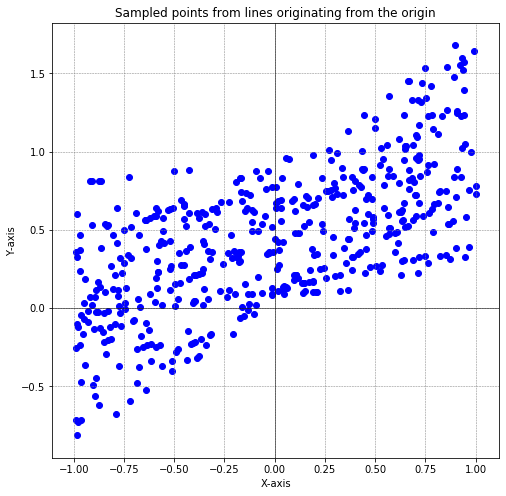

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

def generate_lines(line_params: np.array, x_range: Tuple[float, float] = (-1, 1), num_points: int = 400):
    """
    Generate y values for given slopes and x values.

    Parameters:
    - line_params: Array of parameters for a line, 0th column is the slope and 1st column is the bias.
    - x_range: Tuple indicating the range of x values.
    - num_points: Number of x values to generate.

    Returns:
    - x: x values.
    - lines: Dictionary with slopes as keys and corresponding y values as values.
    """
    x = np.linspace(x_range[0], x_range[1], num_points)
    # [m, mx + b]
    lines = [(line_params[i][0], line_params[i][1], line_params[i][0] * x + line_params[i][1]) for i, slope in enumerate(line_params)]
    return x, lines
     

def sample_points_from_lines(x: np.array, lines: List[Tuple(int, int, float)], num_samples_per_line: int = 10):
    """
    Sample points from given lines.

    Parameters:
    - x: x values.
    - lines: Dictionary with slopes as keys and corresponding y values as values.
    - num_samples_per_line: Number of points to sample per line.

    Returns:
    - sampled_points: List of tuples, each tuple being (x, y) of a sampled point.
    """
    sampled_points = []
    for y_values in lines:
        indices = np.random.choice(len(x), num_samples_per_line, replace=False)
        for index in indices:
            sampled_points.append((x[index], y_values[2][index]))
    return sampled_points

def plot_sampled_points(sampled_points: Tuple[int, int]):
    """
    Plot sampled points.

    Parameters:
    - sampled_points: List of tuples, each tuple being (x, y) of a sampled point.
    """
    plt.figure(figsize=(8, 8))
    for point in sampled_points:
        plt.scatter(*point, marker='o', color='blue')
    
    plt.title("Sampled points from lines originating from the origin")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.show()

if __name__ == "__main__":
    # Set a random seed for reproducibility
    np.random.seed(0)
    num_lines = 50

    # Generate random slopes for 5 lines
    line_params = np.random.uniform(0, 1.0, (num_lines, 2))

    # Generate lines and sample points
    # so, we will probably want to estimate the slopes for the lines
    # using X, we can train a model with the slopes given a line of course
    # but during inference we don't really know whether the sampled points ARE on the line
    # which is why we can try VAE to generate candidates and learn the slope.
    x, lines = generate_lines(line_params)
    #print(lines)
    sampled_points = sample_points_from_lines(x, lines)

    # Plot the sampled points
    plot_sampled_points(sampled_points)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class LineDataset(Dataset):
    def __init__(self, x, lines, num_input_data: int = 10):
        """
        Initialize the LineDataset.

        Parameters:
        - sampled_points: List of tuples, each tuple being (x, y) of a sampled point.
        - labels: Corresponding line/slope identifier for each sampled point.
        """
        self.x = x
        self.lines = lines
        self.num_samples_per_line = num_input_data

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        # y = mx
        slope, bias, y = self.lines[idx]
        indices = np.random.choice(len(y), self.num_samples_per_line, replace=False)
        y = y[indices]
        x = self.x[indices]
        input_tensor = np.concatenate([x,y],axis=0)
        target = np.stack([slope, bias])
        # torch.atan(torch.tensor(slope))
        return torch.tensor(input_tensor), torch.tensor(target)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

# Encoder Network
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

# Decoder Network
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        #x_recon = torch.atan(self.fc2(h))
        out = self.fc2(h)
        return out

# VAE combining the Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, output_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    @torch.no_grad()
    def generate(self, num_samples):
        # Sample from the standard normal distribution (since VAE's latent space is constrained to be close to this distribution)
        # z ~ N(0,1)
        z = torch.randn(num_samples, self.decoder.fc1.in_features)  # Assuming the latent dimension is the input feature size for the decoder's first layer
        # If you have a GPU, you might want to move z to the same device as your model
        #z = z.to(next(self.parameters()).device)
        
        # Decode z to get the data samples
        generated_data = self.decoder(z)
        return generated_data

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

def vae_loss(recon_x, x, mu, log_var):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    # KL divergence loss
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss, kl_loss

def vae_parameter_loss(output_slopes, slopes, mu, log_var):
    # Reconstruction loss
    recon_loss = F.mse_loss(output_slopes, slopes, reduction='mean')
    # KL divergence loss
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss, kl_loss

# Training loop
def train_vae(model, dataloader, optimizer, epochs=10):
    model.train()
    losses = []
    for epoch in range(epochs):
        train_loss = 0
        for i, (input_tensor, target)  in enumerate(dataloader):
            optimizer.zero_grad()
            input_tensor, target = input_tensor.float(), target.float()
            output_slopes, mu, log_var = model(input_tensor)
            
            recon_loss, kl_loss = vae_parameter_loss(output_slopes, target, mu, log_var)
            loss = recon_loss + kl_loss#*0.001
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            if i % 100 == 0:
                losses.append(np.array(losses[-100:]).mean())
                print("kl loss: ", kl_loss.item(), kl_loss.item()*0.001)
                print("recon_loss:", recon_loss.item())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {np.array(losses)[-1000:].mean():.4f}")
    return losses


kl loss:  0.04030401259660721 4.030401259660721e-05
recon_loss: 0.3983539640903473
kl loss:  0.010182973928749561 1.0182973928749562e-05
recon_loss: 0.06150156632065773
kl loss:  0.011137457564473152 1.1137457564473153e-05
recon_loss: 0.060136180371046066
Epoch 1/50, Loss: 0.0886
kl loss:  0.01063980720937252 1.0639807209372521e-05
recon_loss: 0.06413678079843521
kl loss:  0.009169667959213257 9.169667959213257e-06
recon_loss: 0.05806479603052139
kl loss:  0.009783136658370495 9.783136658370495e-06
recon_loss: 0.06645804643630981
Epoch 2/50, Loss: 0.0809
kl loss:  0.009999021887779236 9.999021887779236e-06
recon_loss: 0.06852011382579803
kl loss:  0.011165598407387733 1.1165598407387733e-05
recon_loss: 0.06500817090272903
kl loss:  0.012233267538249493 1.2233267538249494e-05
recon_loss: 0.06023448333144188
Epoch 3/50, Loss: 0.0769
kl loss:  0.010159562341868877 1.0159562341868877e-05
recon_loss: 0.05558987334370613
kl loss:  0.011025204323232174 1.1025204323232174e-05
recon_loss: 0.058

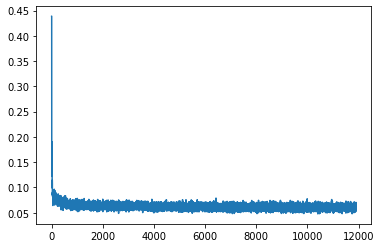

In [7]:
# Hyperparameters
input_dim = 1
hidden_dim = 256
latent_dim = 128
output_dim = 2
learning_rate = 1e-3
epochs = 50
batch_size = 128
num_lines = 30000

# Set a random seed for reproducibility
np.random.seed(0)

# Generate random slopes for 5 lines
line_params = np.random.uniform(0, 1, (num_lines, 2))
#print(line_params)
#raise ValueError()

# Generate lines and sample points
# so, we will probably want to estimate the slopes for the lines
# using X, we can train a model with the slopes given a line of course
# but during inference we don't really know whether the sampled points ARE on the line
# which is why we can try VAE to generate candidates and learn the slope.
x, lines = generate_lines(line_params)

dataset = LineDataset(x, lines, input_dim)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize VAE and optimizer
model = VAE(input_dim*2, hidden_dim, latent_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train VAE
losses = train_vae(model, dataloader, optimizer, epochs=epochs)
plt.plot(losses)
plt.show()

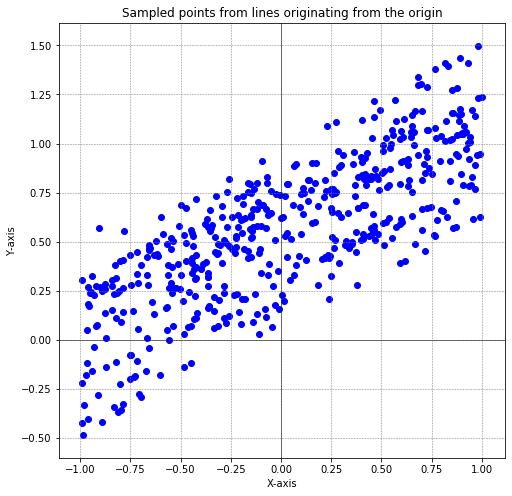

In [9]:
# Hyperparameters
# input_dim = 1
# hidden_dim = 256
# latent_dim = 128
# output_dim = 2
# learning_rate = 1e-3
# epochs = 50
# batch_size = 128
# num_lines = 30000
# model = VAE(input_dim*2, hidden_dim, latent_dim, output_dim)

generated_slopes = model.generate(50)
generated_slopes = generated_slopes.cpu().numpy()

x, lines = generate_lines(generated_slopes)
#print(lines)
sampled_points = sample_points_from_lines(x, lines)

# Plot the sampled points
plot_sampled_points(sampled_points)